### Run graph cut reimplementation from scratch use ford fulkerson algorithm

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
from graph_cut.graphcut_reimplementation.graphcut import GraphCut
from matplotlib import pyplot as plt
import random
import maxflow
import time
import pandas as pd
import networkx as nx

## Maxflow implementation benchmark

In [39]:
import maxflow

# Define the more complicated graph
num_nodes = 8
g = GraphCut(num_nodes)
g_pymaxflow = maxflow.Graph[int](num_nodes, num_nodes)
g_pymaxflow.add_nodes(num_nodes)

# Add edges with capacities
edges = [
    (0, 1, 10),
    (0, 2, 15),
    (1, 2, 25),
    (1, 3, 10),
    (1, 4, 5),
    (2, 4, 15),
    (2, 5, 10),
    (3, 4, 10),
    (3, 6, 5),
    (4, 5, 15),
    (4, 6, 10),
    (5, 7, 20),
    (6, 7, 15)
]

for u, v, w in edges:
    g.add_edge(u, v, w)
    g_pymaxflow.add_edge(u, v, w, w)

source = 0
sink = 7

# Add terminal edges for pymaxflow
g_pymaxflow.add_tedge(source, 0, 1e9)  # Source has infinite outgoing capacity
g_pymaxflow.add_tedge(sink, 1e9, 0)    # Sink has infinite incoming capacity

# Calculate maximum flow using custom implementation
max_flow_custom = g.ford_fulkerson(source, sink)
print("Maximum Flow (Custom):", max_flow_custom)

# Calculate maximum flow using pymaxflow
max_flow_pymaxflow = g_pymaxflow.maxflow()
print("Maximum Flow (PyMaxflow):", max_flow_pymaxflow)


Maximum Flow (Custom): 25
Maximum Flow (PyMaxflow): 25


In [2]:
import maxflow
import time
import pandas as pd

def compare_perf(rows, cols):

    num_nodes = rows * cols

    # Create the graph
    g = GraphCut(num_nodes)
    G_nx = nx.DiGraph()
    g_pymaxflow = maxflow.Graph[int]()
    g_pymaxflow.add_nodes(num_nodes)

    # Add edges for the 4-connected grid
    for i in range(rows):
        for j in range(cols):
            node = i * cols + j
            if j + 1 < cols:  # Connect to the right
                g.add_edge(node, node + 1, 2)
                g_pymaxflow.add_edge(node, node + 1, 2, 0)
                G_nx.add_edge(node, node + 1, capacity=2)
            if j - 1 >= 0:  # Connect to the left
                g.add_edge(node, node - 1, 1)
                g_pymaxflow.add_edge(node, node - 1, 1, 0)
                G_nx.add_edge(node, node - 1, capacity=1)
            if i + 1 < rows:  # Connect downwards
                g.add_edge(node, node + cols, 3)
                g_pymaxflow.add_edge(node, node + cols, 3, 0)
                G_nx.add_edge(node, node + cols, capacity=3)
            if i - 1 >= 0:  # Connect upwards
                g.add_edge(node, node - cols, 1)
                g_pymaxflow.add_edge(node, node - cols, 1, 0)
                G_nx.add_edge(node, node - cols, capacity=1)

    source = num_nodes
    sink = num_nodes + 1
    g.add_node()
    g.add_node()
    for node in range(num_nodes):
        capacity = np.random.randint(1, 10)
        # print(capacity)
        g_pymaxflow.add_tedge(node, capacity, capacity)  
        g.add_edge(node, sink, capacity) 
        g.add_edge(source, node, capacity) 
        G_nx.add_edge(source, node, capacity=capacity)
        G_nx.add_edge(node, sink, capacity=capacity)

    # Calculate maximum flow using custom implementation
    start_time = time.perf_counter()
    max_flow_custom = g.ford_fulkerson(source, sink)
    custom_time = time.perf_counter() - start_time
    # print("Maximum Flow (Custom):", max_flow_custom, custom_time)

    # Calculate maximum flow using pymaxflow
    start_time = time.perf_counter()
    max_flow_pymaxflow = g_pymaxflow.maxflow()
    pymaxflow_time = time.perf_counter() - start_time
    # print("Maximum Flow (PyMaxflow):", max_flow_pymaxflow, pymaxflow_time)

    start_time = time.perf_counter()
    max_flow_nx = nx.maximum_flow_value(G_nx, source, sink)
    nx_time = time.perf_counter() - start_time
    # print("Maximum Flow (NetworkX):", max_flow_nx, nx_time)

    return {
        "rows": rows,
        "cols": cols,
        "num_nodes": num_nodes,
        "custom_time": custom_time,
        "pymaxflow_time": pymaxflow_time,
        "nx_time": nx_time,
        "max_flow_custom": max_flow_custom,
        "max_flow_pymaxflow": max_flow_pymaxflow,
        "max_flow_nx": max_flow_nx
    }

results = []
for rows in [10, 100, 200]:
    for cols in [5, 10,50, 100]:
        print(f"Rows: {rows}, Cols: {cols}")

        results.append(compare_perf(rows, cols))

df = pd.DataFrame(results)
df.head(30)


Rows: 10, Cols: 5
Rows: 10, Cols: 10
Rows: 10, Cols: 50
Rows: 10, Cols: 100
Rows: 100, Cols: 5
Rows: 100, Cols: 10
Rows: 100, Cols: 50
Rows: 100, Cols: 100
Rows: 200, Cols: 5
Rows: 200, Cols: 10
Rows: 200, Cols: 50
Rows: 200, Cols: 100


,rows,cols,num_nodes,custom_time,pymaxflow_time,nx_time,max_flow_custom,max_flow_pymaxflow,max_flow_nx
0,10,5,50,0.001443,0.000020,0.002469,227,227,227
1,10,10,100,0.006572,0.000005,0.007243,459,459,459
2,10,50,500,0.176975,0.000007,0.045285,2480,2480,2480
3,10,100,1000,0.632632,0.000008,0.140767,4829,4829,4829
4,100,5,500,0.138797,0.000007,0.030652,2540,2540,2540
5,100,10,1000,0.585885,0.000033,0.062752,5058,5058,5058
6,100,50,5000,15.984068,0.000020,0.516082,24918,24918,24918
7,100,100,10000,67.117908,0.000195,1.036245,50091,50091,50091
8,200,5,1000,0.544933,0.000009,0.214723,4980,4980,4980
9,200,10,2000,2.507547,0.000013,0.208187,9902,9902,9902


In [ ]:
import time
import numpy as np
import maxflow
from collections import deque, defaultdict
import itertools

def compare_maxflow_implementations(num_nodes, num_edges):
    # Create a graph with random edges
    np.random.seed(0)
    g = GraphCut(num_nodes)
    G_nx = nx.DiGraph()
    g_pymaxflow = maxflow.Graph[int]()
    g_pymaxflow.add_nodes(num_nodes)
    edges = []

    possible_edges = list(itertools.combinations(range(num_nodes), 2))
    random.shuffle(possible_edges)

    for (u, v) in possible_edges[:num_edges]:
        w = random.random()
        G_nx.add_edge(u, v, capacity=w)
        g.add_edge(u, v, w)
        g_pymaxflow.add_edge(u, v, w, 0)
        edges.append((u, v, w))


    source = num_nodes
    sink = num_nodes + 1
    g.add_node()
    g.add_node()
    for node in range(num_nodes):
        capacity = np.random.randint(1, 10)
        G_nx.add_edge(source, node, capacity=capacity)
        G_nx.add_edge(node, sink, capacity=capacity)
        g.add_edge(source, node, capacity)
        g.add_edge(node, sink, capacity)
        g_pymaxflow.add_tedge(node, capacity, 0)  
        g_pymaxflow.add_tedge(node, 0, capacity)  


    # Measure execution time 
    start_time = time.perf_counter()
    max_flow_custom = g.ford_fulkerson(source, sink)
    custom_time = time.perf_counter() - start_time
    # print("Maximum Flow (Custom):", max_flow_custom, custom_time)


    start_time = time.perf_counter()
    max_flow_pymaxflow = g_pymaxflow.maxflow()
    pymaxflow_time = time.perf_counter() - start_time
    # print("Maximum Flow (PyMaxflow):", max_flow_pymaxflow, pymaxflow_time)

    start_time = time.perf_counter()
    max_flow_nx = nx.maximum_flow_value(G_nx, source, sink)
    nx_time = time.perf_counter() - start_time

    return {
        "num_nodes": G_nx.number_of_nodes(),
        "num_edges": G_nx.number_of_edges(),
        "max_flow_custom": max_flow_custom,
        "custom_time": custom_time,
        "max_flow_pymaxflow": max_flow_pymaxflow,
        "pymaxflow_time": pymaxflow_time,
        "max_flow_nx": max_flow_nx,
        "nx_time": nx_time}

# Example usage
results = []
for (num_nodes, num_edges) in [(100,200), (200,600), (500,1000),(1000,2000),(5000,10000),(10000,20000),(15000,30000),(20000,40000)]:
        result = compare_maxflow_implementations(num_nodes, num_edges)
        results.append(result)

# Print results as a table
import pandas as pd

df = pd.DataFrame(results)
df.head(20)


Maximum Flow:  24
Minimum Cut Nodes:  [ True  True  True  True  True  True  True  True  True  True  True False]


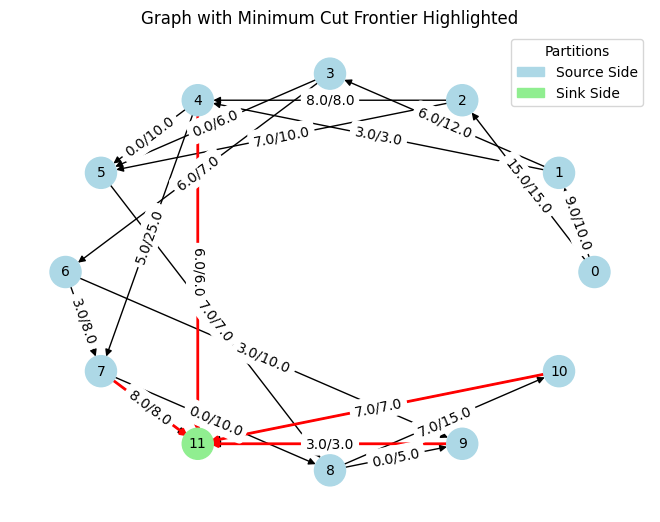

In [20]:
# Example usage with a more complex graph
g = GraphCut(12)

# Adding edges with varying capacities
g.add_edge(0, 1, 10)
g.add_edge(0, 2, 15)
g.add_edge(1, 3, 12)
g.add_edge(1, 4, 3)
g.add_edge(2, 5, 10)
g.add_edge(2, 4, 8)
g.add_edge(3, 6, 7)
g.add_edge(4, 5, 10)
g.add_edge(4, 7, 25)
g.add_edge(5, 8, 7)
g.add_edge(6, 9, 10)
g.add_edge(7, 8, 10)
g.add_edge(8, 9, 5)
g.add_edge(8, 10, 15)
g.add_edge(9, 11, 3)
g.add_edge(10, 11, 7)
g.add_edge(6, 7, 8)
g.add_edge(7,11,8)
g.add_edge(4, 11, 6)
g.add_edge(3, 5, 6)

# Define source and sink
source = 0
sink = 11

# Find maximum flow and minimum cut
max_flow = g.ford_fulkerson(source, sink)
min_cut_nodes = g.min_cut(source)

print("Maximum Flow: ", max_flow)
print("Minimum Cut Nodes: ", min_cut_nodes)

# Visualize the graph and highlight min-cut
g.display_graph_and_min_cut(source, sink)


Maximum Flow:  23
Minimum Cut Nodes:  [ True  True  True False  True False]


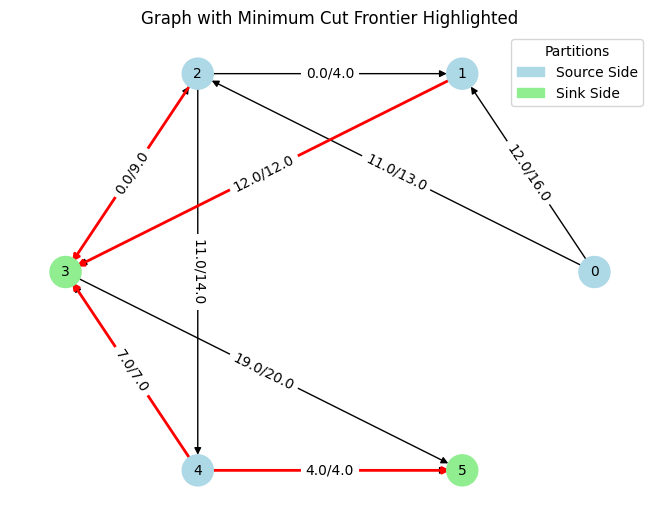

In [73]:
# Example usage 2 (small graph to display result)
g = GraphCut(6)
g.add_edge(0, 1, 16)
g.add_edge(0, 2, 13)
g.add_edge(1, 2, 10)
g.add_edge(1, 3, 12)
g.add_edge(2, 1, 4)
g.add_edge(2, 4, 14)
g.add_edge(3, 2, 9)
g.add_edge(3, 5, 20)
g.add_edge(4, 3, 7)
g.add_edge(4, 5, 4)

source = 0
sink = 5
max_flow = g.ford_fulkerson(source, sink)
min_cut_nodes = g.min_cut(source)

print("Maximum Flow: ", max_flow)
print("Minimum Cut Nodes: ", min_cut_nodes)
g.display_graph_and_min_cut(source, sink)